In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.set_printoptions(suppress=True)

import os
import scanpy as sc
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
anno = pd.read_csv('../LARRY_Analysis/annotations.csv')
anno

clones                    populations
0    Clone 0                        HSC_MPP
1    Clone 1                           MEMP
2    Clone 2                  Megakaryocyte
3    Clone 3                      Mast cell
4    Clone 4                Early Erythroid
5    Clone 5                  Mid Erythroid
6   Clone BG                 Late Erythroid
7        NaN  Neutrophil-myeloid progenitor
8        NaN                             DC
9        NaN             Monocyte precursor
10       NaN                       Monocyte

### Filter adata object

In [3]:
adata = sc.read('./adata_ori.h5ad')
adata.obs

Clusters         _X         _Y  \
SITTE2AACGGGATCAACTGGT         1  21.827168 -34.889477   
SITTE2AAACGAACACGCGCAT         3  -1.034184   1.390855   
SITTE2AACCACACACGACAAG         3  10.530747  -4.849030   
SITTE2AAAGGTACATCTGGGC         6 -29.615807  17.961159   
SITTE2AAACGAAAGCACCCAC         3  23.509193  -1.156073   
...                          ...        ...        ...   
SITTB2TTTCAGTAGACTGGGT         2  21.386005 -19.252357   
SITTB2TTTCCTCAGCCTGCCA         1 -13.000797  -3.205121   
SITTB2TTTCCTCGTGGGAGAG         1 -21.291006  21.387680   
SITTB2TTTCCTCGTGAGCTCC         3  -1.563915   4.886609   
SITTB2TTTGATCAGTCCCGAC         0 -19.799517 -19.348829   

                                            label_def   GFP Timepoint leiden  \
SITTE2AACGGGATCAACTGGT  Neutrophil-myeloid progenitor  GFP+      Day3      2   
SITTE2AAACGAACACGCGCAT                        HSC_MPP  GFP+      Day3      6   
SITTE2AACCACACACGACAAG                Early Erythroid  GFP+      Day3      3   
SITTE2AAAGGTACATCTGGGC                        HSC_MPP  GFP+      Day3      2   
SITTE2AAACGAAAGCACCCAC                        HSC_MPP  GFP+      Day3      2   
...                                               ...   ...       ...    ...   
SITTB2TTTCAGTAGACTGGGT             Monocyte precursor  GFP-     Day10     10   
SITTB2TTTCCTCAGCCTGCCA                      Mast cell  GFP-     Day10      4   
SITTB2TTTCCTCGTGGGAGAG                      Mast cell  GFP-     Day10      4   
SITTB2TTTCCTCGTGAGCTCC             Monocyte precursor  GFP-     Day10     10   
SITTB2TTTGATCAGTCCCGAC             Monocyte precursor  GFP-     Day10     11   

                       label_c    Clone label_c_time  
SITTE2AACGGGATCAACTGGT      c8  Clone_1      c8_Day3  
SITTE2AAACGAACACGCGCAT      c1  Clone_2      c1_Day3  
SITTE2AACCACACACGACAAG      c5  Clone_3      c5_Day3  
SITTE2AAAGGTACATCTGGGC      c1      NaN      c1_Day3  
SITTE2AAACGAAAGCACCCAC      c1      NaN      c1_Day3  
...                        ...      ...          ...  
SITTB2TTTCAGTAGACTGGGT     c10      NaN    c10_Day10  
SITTB2TTTCCTCAGCCTGCCA      c4      NaN     c4_Day10  
SITTB2TTTCCTCGTGGGAGAG      c4      NaN     c4_Day10  
SITTB2TTTCCTCGTGAGCTCC     c10      NaN    c10_Day10  
SITTB2TTTGATCAGTCCCGAC     c10      NaN    c10_Day10  

[46947 rows x 10 columns]

In [6]:
adata_pos = adata[adata.obs['GFP'] == 'GFP+', :]
adata_pos.shape

(29391, 2572)

In [7]:
adata_neg = adata[adata.obs['GFP'] == 'GFP-', :]
adata_neg.shape

(17556, 2572)

In [8]:
adata_pos_barcode = adata_pos[[type(item) == str for item in list(adata_pos.obs['Clone'])], :]
adata_pos_barcode.shape

(17892, 2572)

### Filter clonal info

In [9]:
mat = pd.read_csv('./clone_matrix_yiming.csv', index_col=0) # only GFP+
mat['c7_Day3'] = 0.0
mat

c8_Day3  c1_Day3  c5_Day3  c2_Day3  c4_Day3  c3_Day3  c9_Day3  \
clone_1         1.0      0.0      0.0      0.0      0.0      0.0      0.0   
clone_2         2.0      1.0      0.0      0.0      0.0      0.0      0.0   
clone_3         0.0      0.0      3.0      0.0      1.0      0.0      0.0   
clone_4         0.0      0.0      0.0      0.0      0.0      1.0      0.0   
clone_5         1.0      0.0      0.0      0.0      0.0      0.0      0.0   
...             ...      ...      ...      ...      ...      ...      ...   
clone_1765      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
clone_1766      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
clone_1767      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
clone_1768      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
clone_1769      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

            c10_Day3  c11_Day3  c6_Day3  ...  c4_Day17  c6_Day17  c7_Day17  \
clone_1          0.0       0.0      0.0  ...       0.0       0.0       0.0   
clone_2          0.0       0.0      0.0  ...       0.0       0.0       0.0   
clone_3          0.0       0.0      0.0  ...       0.0       0.0       0.0   
clone_4          0.0       0.0      0.0  ...       0.0       0.0       0.0   
clone_5          0.0       0.0      0.0  ...       0.0       0.0       0.0   
...              ...       ...      ...  ...       ...       ...       ...   
clone_1765       0.0       0.0      0.0  ...       0.0       0.0       0.0   
clone_1766       0.0       0.0      0.0  ...       0.0       0.0       1.0   
clone_1767       0.0       0.0      0.0  ...       0.0       0.0       1.0   
clone_1768       0.0       0.0      0.0  ...       0.0       0.0       1.0   
clone_1769       0.0       0.0      0.0  ...       0.0       1.0       0.0   

            c10_Day17  c8_Day17  c3_Day17  c1_Day17  c9_Day17  c2_Day17  \
clone_1           0.0       0.0       0.0       0.0       0.0       0.0   
clone_2           0.0       0.0       0.0       0.0       0.0       0.0   
clone_3           0.0       0.0       0.0       0.0       0.0       0.0   
clone_4           0.0       0.0       0.0       0.0       0.0       0.0   
clone_5           0.0       0.0       0.0       0.0       0.0       0.0   
...               ...       ...       ...       ...       ...       ...   
clone_1765        0.0       0.0       0.0       0.0       0.0       0.0   
clone_1766        0.0       0.0       0.0       0.0       0.0       0.0   
clone_1767        0.0       0.0       0.0       0.0       0.0       0.0   
clone_1768        0.0       0.0       0.0       0.0       0.0       0.0   
clone_1769        0.0       0.0       0.0       0.0       0.0       0.0   

            c7_Day3  
clone_1         0.0  
clone_2         0.0  
clone_3         0.0  
clone_4         0.0  
clone_5         0.0  
...             ...  
clone_1765      0.0  
clone_1766      0.0  
clone_1767      0.0  
clone_1768      0.0  
clone_1769      0.0  

[1769 rows x 33 columns]

In [10]:
print (mat.sum().sum())
print (mat[[i for i in mat.columns if i.endswith('Day3')]].sum().sum())
print (adata_pos[adata_pos.obs['Timepoint'].values == 'Day3', :].shape)
print (mat[[i for i in mat.columns if i.endswith('Day10')]].sum().sum())
print (adata_pos[adata_pos.obs['Timepoint'].values == 'Day10', :].shape)
print (mat[[i for i in mat.columns if i.endswith('Day17')]].sum().sum())
print (adata_pos[adata_pos.obs['Timepoint'].values == 'Day17', :].shape)

17892.0
2145.0
(3469, 2572)
4136.0
(7586, 2572)
11611.0
(18336, 2572)


In [11]:
mat = sc.AnnData(mat, dtype=np.float32)
cols_ori = mat.var.index
mat

AnnData object with n_obs × n_vars = 1769 × 33

In [12]:
# create megaclones
sc.pp.filter_cells(mat, min_counts=5) # or more
sc.pp.filter_genes(mat, min_counts=1) # or more

In [13]:
mat

AnnData object with n_obs × n_vars = 372 × 28
    obs: 'n_counts'
    var: 'n_counts'

### Analysis of clonal info

In [14]:
cols_ori.difference(mat.var.index)

Index(['c10_Day3', 'c11_Day3', 'c6_Day3', 'c7_Day10', 'c7_Day3'], dtype='object')

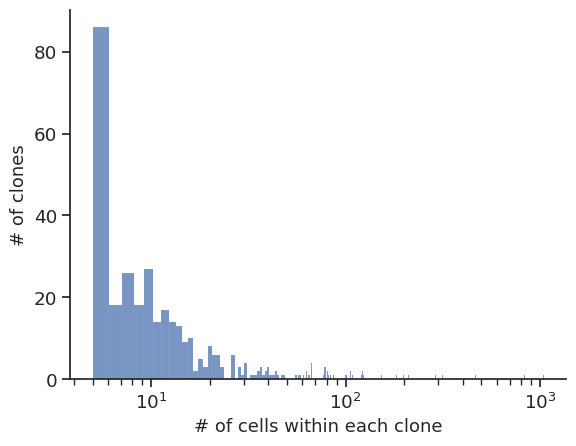

In [16]:
sns.set_theme(style='ticks', font_scale=1.2)
ax = sns.histplot(mat.obs.n_counts.values, bins=1000)
plt.xscale('log')
plt.xlabel('# of cells within each clone', fontsize=13)
plt.ylabel('# of clones', fontsize=13)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('./cellnumber.svg', dpi=600, bbox_inches='tight', transparent=False, facecolor='white')

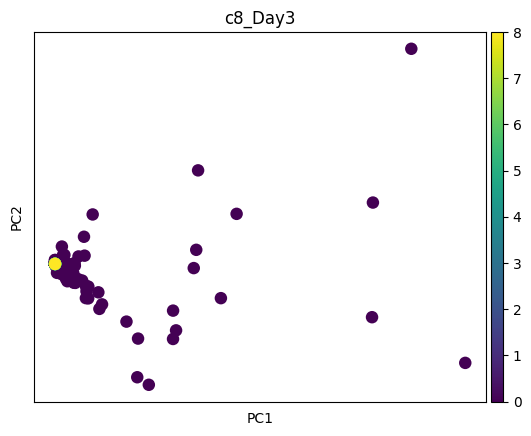

In [15]:
sc.tl.pca(mat)
sc.pl.pca(mat, color='c8_Day3')

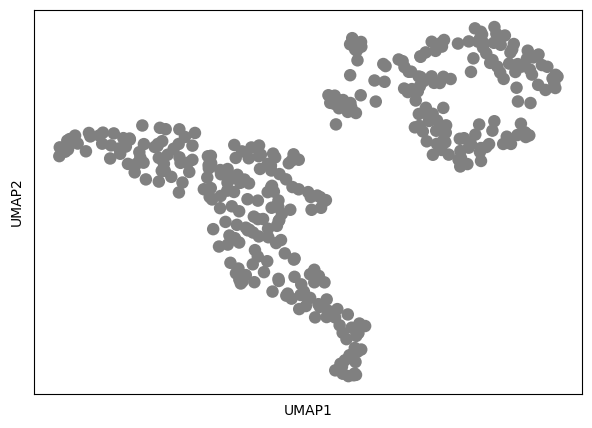

In [16]:
sc.pp.neighbors(mat)
sc.tl.umap(mat)
sc.pl.scatter(mat, basis='umap')

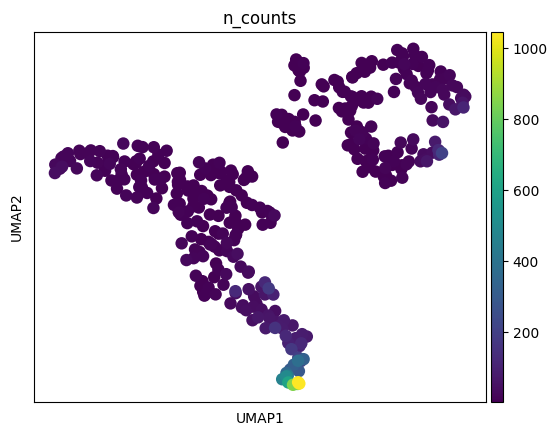

In [17]:
sc.pl.umap(mat, color='n_counts', legend_loc='on data')

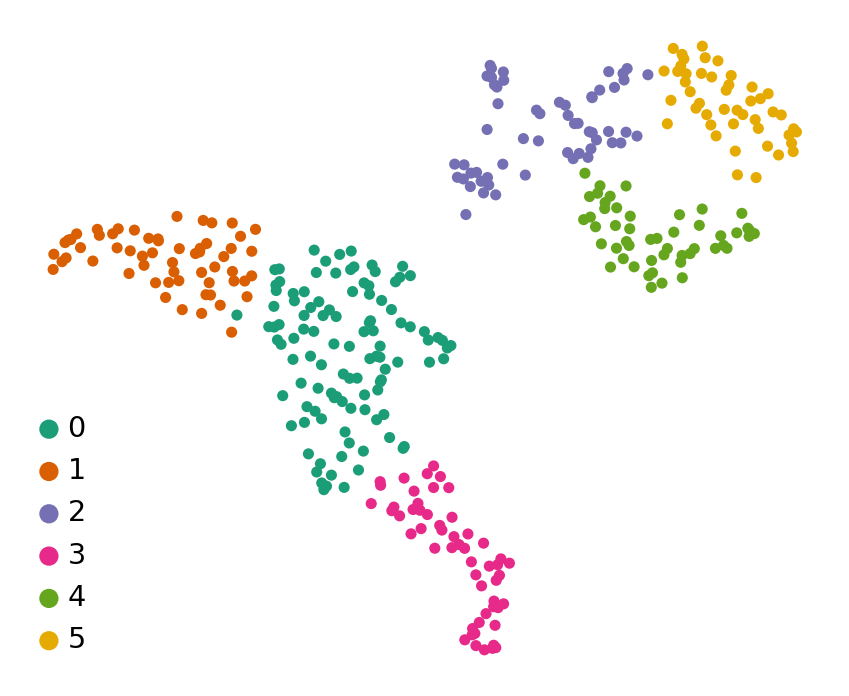

In [18]:
sc.set_figure_params(dpi_save=600, format='svg', figsize=(6, 5))
sc.tl.leiden(mat, resolution=.5)
sc.pl.scatter(mat, basis='umap', color='leiden', legend_loc='best', size=100, save='leiden.svg', title='', frameon=False, palette=sns.color_palette('Dark2'))

In [19]:
mat.obs.leiden.value_counts()

0    108
1     58
2     56
3     54
4     50
5     46
Name: leiden, dtype: int64

In [20]:
adata_pos_barcode_filter = adata_pos_barcode[[item in mat.var.index for item in list(adata_pos_barcode.obs['label_c_time'])], :]
print (adata_pos_barcode_filter.shape)
adata_pos_barcode_filter = adata_pos_barcode_filter[[item.lower() in mat.obs.index for item in list(adata_pos_barcode_filter.obs['Clone'])], :]
print (adata_pos_barcode_filter.shape)
print (mat.X.sum().sum())

(17872, 2572)
(15695, 2572)
15695.0


### UMAP related plots

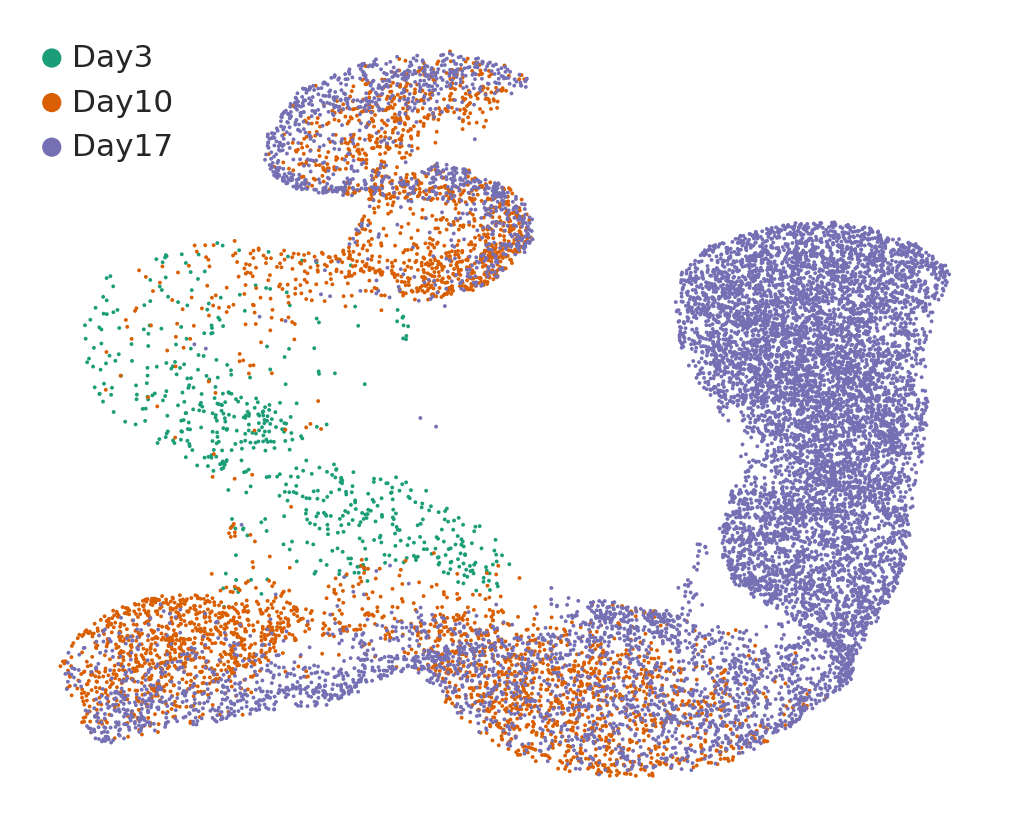

In [30]:
sc.set_figure_params(dpi_save=600, format='svg', figsize=(7, 6))
sc.pl.scatter(adata_pos_barcode_filter, basis='umap', color='Timepoint', 
              legend_loc='upper left', palette=sns.color_palette('Dark2'), 
              save='timepoints.svg', size=12, frameon=False, title='',
              legend_fontsize=14)

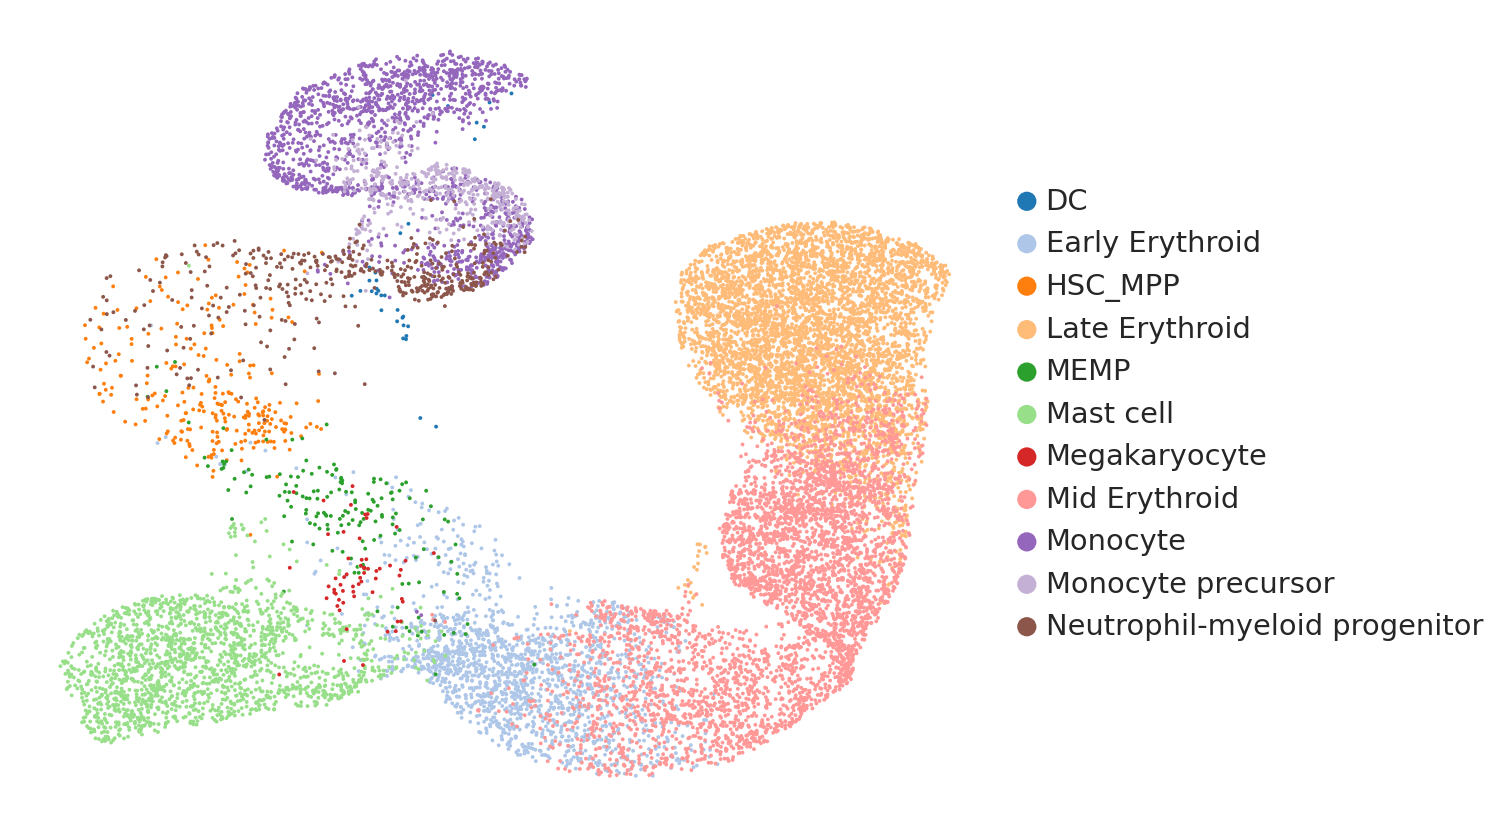

In [34]:
adata_pos_barcode_filter.obs['Populations'] = adata_pos_barcode_filter.obs['label_def']
sc.set_figure_params(dpi_save=600, format='svg', figsize=(7, 6))
sc.pl.scatter(adata_pos_barcode_filter, basis='umap', color='Populations', 
              legend_loc='right margin', palette=sns.color_palette('tab20'), 
              save='populations.svg', size=12, frameon=False, 
              title='', legend_fontsize=13)

/data/users/mingzegao/.conda/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


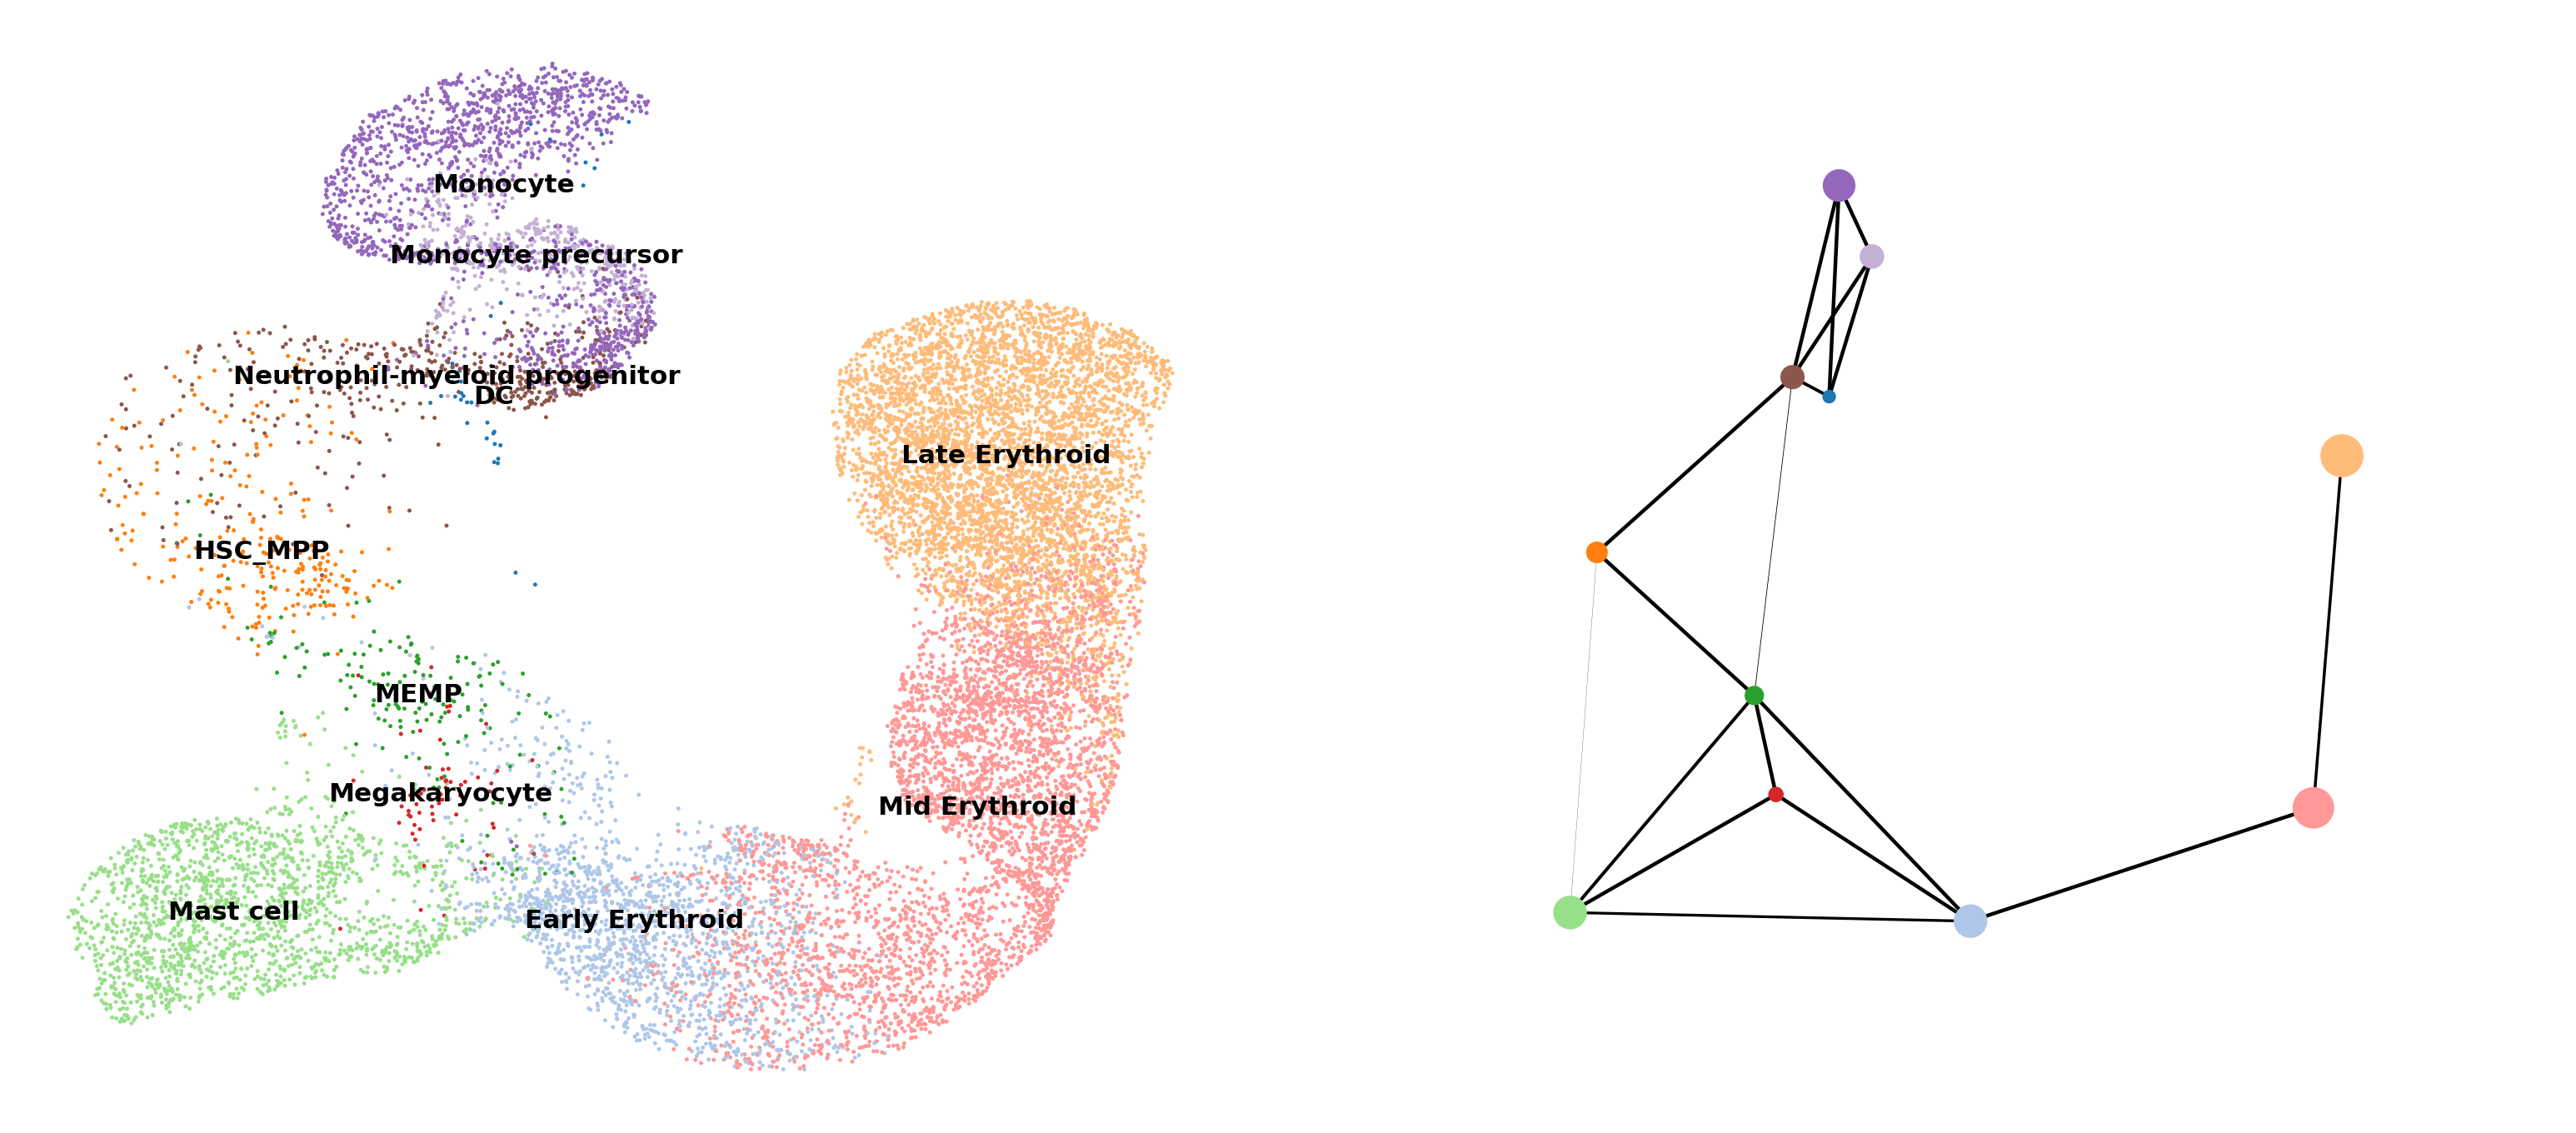

In [25]:
sc.set_figure_params(dpi_save=600, format='svg', figsize=(10, 10))
sc.tl.paga(adata_pos_barcode_filter, groups='label_def')
sc.pl.paga_compare(
    adata_pos_barcode_filter, basis='umap', palette=sns.color_palette('tab20'), 
    save='_supplement_paga.svg', size=20, frameon=False, 
    title='', edge_width_scale=0.75, max_edge_width=2, 
    labels=['' for i in range(len(set(adata_pos_barcode_filter.obs['label_def'])))]
)

### Generate model inputs

In [26]:
time = [3, 10, 17]
size_leiden = len(set(mat.obs.leiden))
size_time = len(time)
size_pops = len(set(adata.obs.label_def))

In [29]:
from natsort import natsorted
leiden = list(set(mat.obs.leiden))
leiden = natsorted(leiden)
leiden

['0', '1', '2', '3', '4', '5']

In [34]:
mat.X.sum().sum()

15695.0

In [31]:
kinetics_not_norm = np.zeros((size_leiden + 1, size_time, size_pops), dtype=np.float32)

for idi, leid in enumerate(leiden):
    for idj, time in enumerate([3, 10, 17]):
        for idk, pop in enumerate(['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10','c11']):
            if pop + '_Day' + str(time) in mat.var_names:
                kinetics_not_norm[idi, idj, idk] = \
                    np.array(mat[mat.obs.leiden == leid, mat.var_names == (pop + '_Day' + str(time))].X).sum()

In [32]:
kinetics_not_norm.sum()

15695.0

In [41]:
for idj, time in enumerate([3, 10, 17]):
    for idk, pop in enumerate(['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10','c11']):
        if pop + '_Day' + str(time) in adata.obs['label_c_time'].values:
            num = adata[adata.obs['label_c_time'] == (pop + '_Day' + str(time)), :].shape[0]
            if str(time) == '3':
                num *= 11000 / 3469
            if str(time) == '10':
                num *= 620000*(110/35) / 7586
            if str(time) == '17':
                num *= 126000000*(6200/6125)*(110/35) / 18366
            kinetics_not_norm[-1, idj, idk] = num

In [42]:
kinetics_not_norm.sum()

403666880.0

In [47]:
np.savetxt('../V3_Mingze/kinetics_array_sequenced.txt', np.reshape(kinetics_not_norm, (size_leiden + 1, size_time * size_pops)))

In [43]:
len(set(adata.obs['Clone']))

1757

In [35]:
fig, ax = plt.subplots(size_leiden, size_pops, figsize=(22, 15))

for i in range(size_leiden):
    for j in range(size_pops):
        ax[i][j].plot([3, 10, 17], kinetics_not_norm[i, :, j])

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)

### Filtered adata

In [46]:
leiden = []
for clone in adata_pos_barcode_filter.obs['Clone'].values:
    leiden.append(mat.obs.loc[clone.lower()]['leiden'])
adata_pos_barcode_filter.obs['Meta clones'] = leiden

In [47]:
adata_pos_barcode_filter.obs

Clusters         _X         _Y        label_def   GFP  \
SITTE2AACCTGATCAAATGCC         0  11.024174  26.616690             MEMP  GFP+   
SITTE2AAAGGATAGACTTCGT         7  -9.395693  17.708481  Early Erythroid  GFP+   
SITTE2AACAACCGTTCTCACC         6 -21.183458  19.348639             MEMP  GFP+   
SITTE2AACCAACCATTCTCTA         3  19.790131  -8.153334               DC  GFP+   
SITTE2AAACGAAAGTATAGAC         4 -45.582912   5.186813             MEMP  GFP+   
...                          ...        ...        ...              ...   ...   
SITTA1TTTGACTGTAGGTACG         3 -46.357494   7.715984    Mid Erythroid  GFP+   
SITTA1TTTGTTGAGCATATGA         1  -3.308680 -18.662312   Late Erythroid  GFP+   
SITTA1TTTCGATGTTAAGAAC         6 -14.730787 -34.450024   Late Erythroid  GFP+   
SITTA1TTTGACTCAGTGGGTA         0  30.530634  26.517096   Late Erythroid  GFP+   
SITTA1TTTCGATTCAGCATTG         0  22.393101  33.933804   Late Erythroid  GFP+   

                       Timepoint leiden label_c       Clone label_c_time  \
SITTE2AACCTGATCAAATGCC      Day3      3      c2     Clone_7      c2_Day3   
SITTE2AAAGGATAGACTTCGT      Day3      3      c5    Clone_14      c5_Day3   
SITTE2AACAACCGTTCTCACC      Day3      3      c2    Clone_16      c2_Day3   
SITTE2AACCAACCATTCTCTA      Day3     18      c9    Clone_17      c9_Day3   
SITTE2AAACGAAAGTATAGAC      Day3      3      c2    Clone_20      c2_Day3   
...                          ...    ...     ...         ...          ...   
SITTA1TTTGACTGTAGGTACG     Day17      8      c6   Clone_565     c6_Day17   
SITTA1TTTGTTGAGCATATGA     Day17     14      c7   Clone_854     c7_Day17   
SITTA1TTTCGATGTTAAGAAC     Day17     14      c7  Clone_1067     c7_Day17   
SITTA1TTTGACTCAGTGGGTA     Day17      5      c7   Clone_565     c7_Day17   
SITTA1TTTCGATTCAGCATTG     Day17      1      c7  Clone_1739     c7_Day17   

                            Populations Meta clones  
SITTE2AACCTGATCAAATGCC             MEMP           0  
SITTE2AAAGGATAGACTTCGT  Early Erythroid           1  
SITTE2AACAACCGTTCTCACC             MEMP           0  
SITTE2AACCAACCATTCTCTA               DC           2  
SITTE2AAACGAAAGTATAGAC             MEMP           0  
...                                 ...         ...  
SITTA1TTTGACTGTAGGTACG    Mid Erythroid           3  
SITTA1TTTGTTGAGCATATGA   Late Erythroid           3  
SITTA1TTTCGATGTTAAGAAC   Late Erythroid           3  
SITTA1TTTGACTCAGTGGGTA   Late Erythroid           3  
SITTA1TTTCGATTCAGCATTG   Late Erythroid           3  

[15695 rows x 12 columns]

In [48]:
adata.obs['Meta clones'] = np.zeros(adata.shape[0]) - 1
for i in list(adata_pos_barcode_filter.obs.index):
    adata.obs.at[i, 'Meta clones'] = adata_pos_barcode_filter.obs.loc[i]['Meta clones']
adata.obs['Meta clones'] = [str(i) for i in adata.obs['Meta clones']]

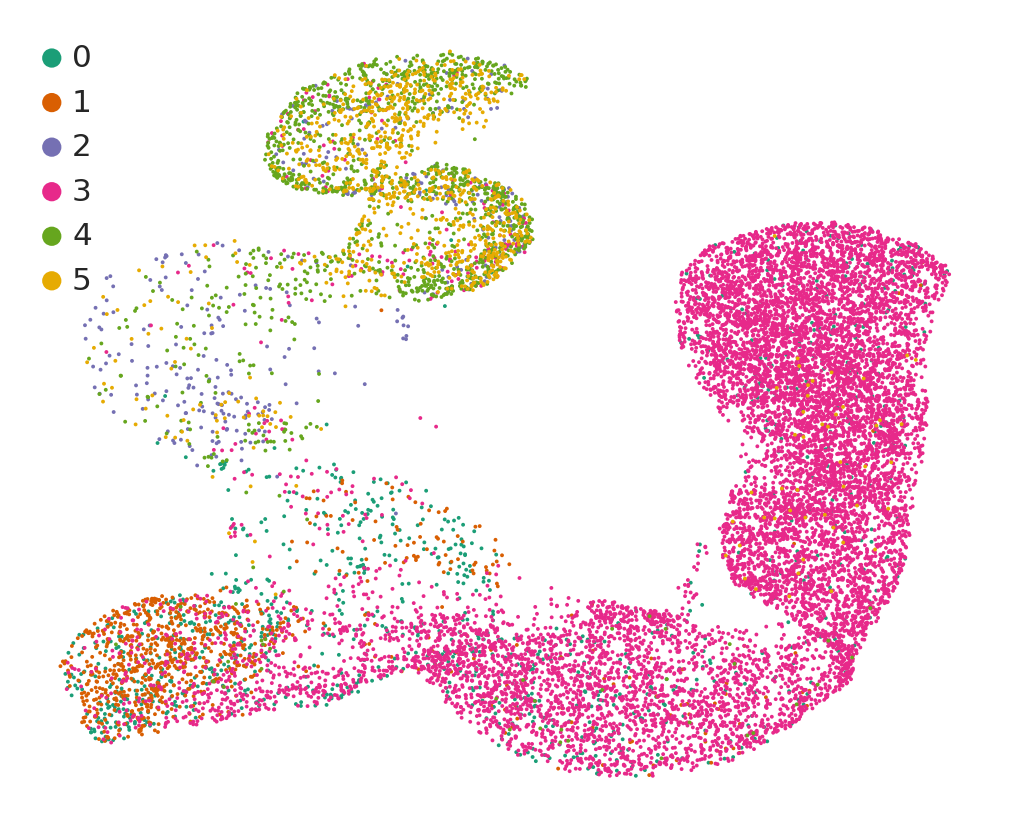

In [49]:
sc.set_figure_params(dpi_save=600, format='svg', figsize=(7, 6))
sc.pl.scatter(adata_pos_barcode_filter, basis='umap', color='Meta clones', 
              legend_loc='upper left', palette=sns.color_palette('Dark2'), 
              save='metaclones.svg', size=12, frameon=False,
              title='', legend_fontsize=14)

In [50]:
adata.write('./adata_megas.h5ad')